In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
import math, os
from sklearn.preprocessing import label_binarize

def getfile(filename):
    root=''
    file = root+filename
    if '.csv' not in filename:
        file = file+'.csv'
    df = pd.read_csv(file,header=None)
    df = np.asarray(df)

    labels=[]
    for i, c in enumerate(os.listdir(root+"../MEL/val/")):
        for j in range(len(os.listdir(root+"../MEL/val/"+c))):
            labels.append(i)
    labels = np.asarray(labels)
    return df,labels

#ROC-AUC
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
def plot_roc(val_label,decision_val, caption='ROC Curve'):
    num_classes=np.unique(val_label).shape[0]
    classes = []
    for i in range(num_classes):
        classes.append(i)
    plt.figure()
    decision_val = label_binarize(decision_val, classes=classes)
    
    if num_classes!=2:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            y_val = label_binarize(val_label, classes=classes)
            fpr[i], tpr[i], _ = roc_curve(y_val[:, i], decision_val[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(i+1, roc_auc[i]))
    else:
        fpr,tpr,_ = roc_curve(val_label,decision_val, pos_label=1)
        roc_auc = auc(fpr,tpr)*100
        plt.plot(fpr,tpr,label='ROC curve (AUC=%0.2f)'%roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc="lower right")
    plt.savefig(str(len(classes))+'testRAVDESS.png',dpi=300)

def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

def metrics(labels,predictions,classes):
    print("Classification Report:")
    print(classification_report(labels, predictions, target_names = classes,digits = 4))
    matrix = confusion_matrix(labels, predictions)
    print("Confusion matrix:")
    print(matrix)
    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))
    print("\nBalanced Accuracy Score: ",balanced_accuracy_score(labels,predictions))

def fuzzy_rank(CF, top):
    R_L = np.zeros(CF.shape)
    for i in range(CF.shape[0]):
        for j in range(CF.shape[1]):
            for k in range(CF.shape[2]):
                R_L[i][j][k] = 1 - math.exp(-math.exp(-2.0*CF[i][j][k]))  #Gompertz Function
    
    K_L = 0.632*np.ones(shape = R_L.shape) #initiate all values as penalty values
    for i in range(R_L.shape[0]):
        for sample in range(R_L.shape[1]):
            for k in range(top):
                a = R_L[i][sample]
                idx = np.where(a==np.partition(a, k)[k])
                #if sample belongs to top 'k' classes, R_L =R_L, else R_L = penalty value
                K_L[i][sample][idx] = R_L[i][sample][idx]

    return K_L

def CFS_func(CF, K_L):
    H = CF.shape[0] #no. of classifiers
    for f in range(CF.shape[0]):
        for i in range(CF.shape[1]):
            idx = np.where(K_L[f][i] == 0.632)
            CF[f][i][idx] = 0
    CFS = 1 - np.sum(CF,axis=0)/H
    return CFS

def Gompertz(top = 2, *argv):
    L = 0 #Number of classifiers
    for arg in argv:
        L += 1

    num_classes = arg.shape[1]
    CF = np.zeros(shape = (L,arg.shape[0], arg.shape[1]))

    for i, arg in enumerate(argv):
        CF[:][:][i] = arg

    R_L = fuzzy_rank(CF, top) #R_L is with penalties
    
    RS = np.sum(R_L, axis=0)
    CFS = CFS_func(CF, R_L)
    FS = RS*CFS

    predictions = np.argmin(FS,axis=1)
    return predictions


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('drive/MyDrive/RAVDESS/Scripts')
os.listdir()

['runs',
 'probability_extraction_resnet.ipynb',
 'probability_extraction_inception.ipynb',
 'Copy of probability_extraction_googlenet.ipynb',
 'runstest',
 'probability_extraction.ipynb',
 'notebookmain.ipynb']

['1', '2', '3', '4', '5', '6', '7', '8']
Classification Report:
              precision    recall  f1-score   support

           1     0.4915    1.0000    0.6591        58
           2     0.5000    0.5000    0.5000       116
           3     0.5000    0.5000    0.5000       116
           4     0.5088    0.5000    0.5043       116
           5     0.5000    0.5000    0.5000       116
           6     0.9831    0.5000    0.6629       116
           7     1.0000    0.9914    0.9957       116
           8     1.0000    1.0000    1.0000       116

    accuracy                         0.6655       870
   macro avg     0.6854    0.6864    0.6652       870
weighted avg     0.6983    0.6655    0.6657       870

Confusion matrix:
[[ 58   0   0   0   0   0   0   0]
 [ 58  58   0   0   0   0   0   0]
 [  0  58  58   0   0   0   0   0]
 [  0   0  58  58   0   0   0   0]
 [  2   0   0  56  58   0   0   0]
 [  0   0   0   0  58  58   0   0]
 [  0   0   0   0   0   1 115   0]
 [  0   0   0   0   0 

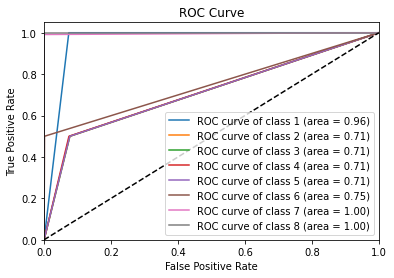

In [8]:
# from utils_ensemble import *
# import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('--data_directory', type=str, default = '../Speech_CSV', help='Directory where csv files are stored')
# parser.add_argument('--topk', type=int, default = 2, help='Top-k number of classes')
# args = parser.parse_args()

# root = args.data_directory
# if not root[-1]=='/':
#     root=root+'/'

root = '../Speech_CSV_ravdess_test/'

p1,labels = getfile(root+"GoogleNetModel")
# p2,_ = getfile(root+"inceptionEMODB")
# p3,_ = getfile(root+"ResnetModel")
 # p3,_ = getfile(root+"inception")

#Check utils_ensemble.py to see the "labels" distribution. Change according to the dataset used. By default it has been set for the SARS-COV-2 dataset.

#Calculate Gompertz Function Ensemble
top = 2 #top 'k' classes
predictions = Gompertz(top, p1)

correct = np.where(predictions == labels)[0].shape[0]
total = labels.shape[0]

# print("Accuracy = ",correct/total)
classes = []
for i in range(p1.shape[1]):
    classes.append(str(i+1))
print(classes)

metrics(labels,predictions,classes)

plot_roc(labels,predictions)